# load the packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# load the grid

In [2]:
# define basin we want
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rhoconstFresh': 1000,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'SEAICEheatConsFix': 0,
    'conserveTr': 0,
    'seaice_variable_salinity_flag': 0
}

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [11]:
mymsk3 = np.tile(mymsk[np.newaxis,:,:],(nz,1,1)) * mygrid['hFacC']
mymsk3.shape

(50, 1350, 270)

# timesteps

In [12]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# the following will need to be modified if we look at multiple time steps
# dt = datetimes[1]-datetimes[0]   # days
# dt = dt.total_seconds()

# ocean and ice
AB_gT=0
AB_gS=0

In [113]:
# years = list(np.arange(2003,2018,1))  # 15 year period
years = [2014]
years = [str(i) for i in years]
years = np.array(years)
# years

In [114]:
# write the datetimes for the later period
times = {}

for year in years:
    times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr.shape
datetimes.shape

(12,)

In [115]:
# for one year
tsstr = tsstr[:13]
datetimes = datetimes[:13]
datetimes.shape

(12,)

In [116]:
# 'datetimes' is a list of datetime objects
dt = [(datetimes[i+1] - datetimes[i]).total_seconds() for i in range(len(datetimes) - 1)]
dt = np.array(dt)
dt.shape

(11,)

# load a file we want to create a time series of 

In [117]:
# we will want to load only one file at a time so that we don't overload the memory
# load these files
    # Ocean temperature, air temperature, sensible heat are all things to look at
    # Sea ice

In [118]:
# let's do this for sea ice alone so we can look here
# we'll set the datetimes each time so that we can look each time without loading all the files
# tsstr

In [26]:
# for each year, read all the files, add the total to an example array so we can plot
# also append the datetimes to a total for the datetimes

# read fluxes
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_snap_set1["fldList"])
varnames = np.array(["SIarea"])   # add in other terms to look at balance
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

SIarea = np.zeros((len(tsstr),ny,nx))
for t in range(len(tsstr)):
    # retrieve the current value and add it to the list
    tmpSIarea,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[t]),returnmeta=True,rec=recs[0])   # m^2/m^2
    SIarea[t] = tmpSIarea.reshape(ny,nx) * mymsk  # mask with the Barents Sea so we can look at this

# create the values for the plot
# get the median sea ice thickness at each point
total_SIarea = np.zeros((len(tsstr)))
# get the median sea ice value
for i in range(len(tsstr)):
    # maybe we should look at the total SIarea
    total_SIarea[i] = np.nansum(SIarea[i])

del SIarea

In [27]:
drf3d.shape

(50, 1350, 270)

In [28]:
# also load the temperature of the ocean, we can create arrays both for SST and for mean ocean temperature
# we should use SALTDR and THETADR rather so that these are weighted, then divide by drF


file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR","THETADR"])   # add in other terms to look at balance
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# let's just grab the median value here when we do the loop
# create the values for the plot
median_theta = np.zeros((len(tsstr)))
median_salt = np.zeros((len(tsstr)))
median_theta_surf = np.zeros((len(tsstr)))
median_salt_surf = np.zeros((len(tsstr)))

for t in range(len(tsstr)):
    if t%12 == 0:
        print(t)
    # retrieve the current value and add it to the list
    tmpSALT,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[t]),returnmeta=True,rec=recs[0])
    tmpSALT = tmpSALT.reshape(nz,ny,nx)   # PSU
    tmpTHETA,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[t]),returnmeta=True,rec=recs[1])
    tmpTHETA = tmpTHETA.reshape(nz,ny,nx) # degC
        
    # do for total ocean
    median_salt[t] = np.nanmean((tmpSALT * mymsk3)/drf3d)
    median_theta[t] = np.nanmean((tmpTHETA * mymsk3)/drf3d)

    # do for surface
    median_salt_surf[t] = np.nanmean((tmpSALT[0] * mymsk)/drf3d[0]) # only look at the surface k=0
    median_theta_surf[t] = np.nanmean((tmpTHETA[0] * mymsk)/drf3d[0]) # only look at the surface k=0

    del tmpSALT,tmpTHETA

0


In [ ]:
# FIX NAMES! THESE ARE NOT MEDIAN!!!

In [50]:
# can do for sensible heat flux given from the atmosphere: "EXFhs from exf_zflux_set1"
# note this is not the total heat RECEIVED by the ocean

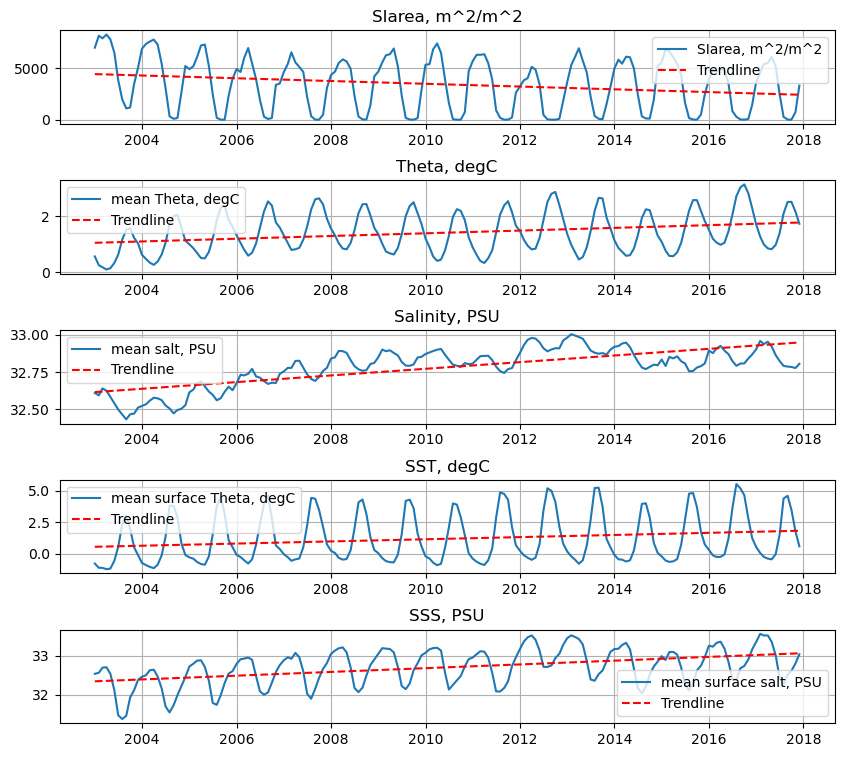

In [56]:
fig = plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space



# do trendline for SI
coefficients = np.polyfit(np.arange(len(datetimes)), total_SIarea, 1)
trendline = np.polyval(coefficients, np.arange(len(datetimes)))
# Create the plot
ax = plt.subplot(511)
ax.grid()
ax.plot(datetimes, total_SIarea, label="SIarea, m^2/m^2")
ax.plot(datetimes, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("SIarea, m^2/m^2")
ax.legend()

# trendline
coefficients = np.polyfit(np.arange(len(datetimes)), median_theta, 1)
trendline = np.polyval(coefficients, np.arange(len(datetimes)))
# plot for theta
ax = plt.subplot(512)
ax.grid()
ax.plot(datetimes, median_theta, label="mean Theta, degC")
ax.plot(datetimes, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("Theta, degC")
ax.legend()

# trendline
coefficients = np.polyfit(np.arange(len(datetimes)), median_salt, 1)
trendline = np.polyval(coefficients, np.arange(len(datetimes)))
# plot for salt
ax = plt.subplot(513)
ax.grid()
ax.plot(datetimes, median_salt, label="mean salt, PSU")
ax.plot(datetimes, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("Salinity, PSU")
ax.legend()

# trendline
coefficients = np.polyfit(np.arange(len(datetimes)), median_theta_surf, 1)
trendline = np.polyval(coefficients, np.arange(len(datetimes)))
# plot for theta
ax = plt.subplot(514)
ax.grid()
ax.plot(datetimes, median_theta_surf, label="mean surface Theta, degC")
ax.plot(datetimes, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("SST, degC")
ax.legend()

# trendline
coefficients = np.polyfit(np.arange(len(datetimes)), median_salt_surf, 1)
trendline = np.polyval(coefficients, np.arange(len(datetimes)))
# plot for salt
ax = plt.subplot(515)
ax.grid()
ax.plot(datetimes, median_salt_surf, label="mean surface salt, PSU")
ax.plot(datetimes, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("SSS, PSU")
ax.legend()


# plt.savefig(path + "basic_intro_trendlines.png",dpi=300)
plt.show()

# create the J terms

In general, when we create the time-mean for these terms we are interested in the mean weighted by depth

### For salt

We need to find a way to do this more efficiently

In [119]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1:, :, :,:] - SALTDR[:-1, :,:, :]) / dt[:,np.newaxis,np.newaxis,np.newaxis]    # PSU.m/s
SALTDR.shape

(11, 50, 1350, 270)

In [60]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * np.tile(mk3D_mod(RAC,SALTDR[0])[np.newaxis,:,:,:],(SALTDR.shape[0],1,1,1))    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean
budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=1)

In [147]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# do this onle for datetimes[1:] so we can set it in the file
saltfluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
advfluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
dffluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
                     
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t + 1])
    # read the files
    ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
    DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
    
    tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
    tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)
    
    # reshape and get the faces
    tmpUo = tmpUo.reshape(nz,ny,nx)
    tmpVo = tmpVo.reshape(nz,ny,nx)
    tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
    tmpVo = get_aste_faces(tmpVo,nfx,nfy)

    # set in the larger array
    saltfluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)


    # also do for adv and df
    tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
    tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
    advfluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

    tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
    tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
    dffluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s


budgO['saltfluxes']['hconv'] = saltfluxeshconv
budgO['saltfluxes']['ADV_hconv'] = advfluxeshconv
budgO['saltfluxes']['DF_hconv'] = dffluxeshconv

In [149]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX",'oceFWflx','SIatmFW'])   # add in other terms to look at balance
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# read all the files
oceSPflx = np.zeros((len(tsstr)-1,ny,nx))
SFLUX = np.zeros((len(tsstr)-1,ny,nx))
oceFWflx = np.zeros((len(tsstr)-1,ny,nx))
SIatmFW = np.zeros((len(tsstr)-1,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps
    
    tmpoceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])   # g/m^2/s
    tmpSFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])      # g/m^2/s
    tmpoceFWflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])   # kg/m^2/s
    tmpSIatmFW,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])    # kg/m^2/s

    tmpoceSPflx = tmpoceSPflx.reshape(ny,nx)
    tmpSFLUX = tmpSFLUX.reshape(ny,nx)
    tmpoceFWflx = tmpoceFWflx.reshape(ny,nx)
    tmpSIatmFW = tmpSIatmFW.reshape(ny,nx)

    # add to bigger array
    oceSPflx[t] = tmpoceSPflx
    SFLUX[t] = tmpSFLUX
    oceFWflx[t] = tmpoceFWflx
    SIatmFW[t] = tmpSIatmFW

# array to store all the files
oceSflux = np.zeros((len(tsstr)-1,ny,nx))
WSLTMASS = np.zeros((len(tsstr)-1,ny,nx))
SRELAX = np.zeros((len(tsstr)-1,ny,nx))

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])

    tmpoceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpWSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpSRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpoceSflux = tmpoceSflux.reshape(ny,nx)
    tmpWSLTMASS = tmpWSLTMASS.reshape(ny,nx)
    tmpSRELAX = tmpSRELAX.reshape(ny,nx)

    # add to bigger array
    oceSflux[t] = tmpoceSflux
    WSLTMASS[t] = tmpWSLTMASS
    SRELAX[t] = tmpSRELAX

In [150]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

oceSPtnd = np.zeros((len(tsstr)-1,nz,ny,nx))
KPPg_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpoceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpKPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpoceSPtnd = tmpoceSPtnd.reshape(nz,ny,nx)
    tmpKPPg_SLT = tmpKPPg_SLT.reshape(nz,ny,nx)

    oceSPtnd[t] = tmpoceSPtnd
    KPPg_SLT[t] = tmpKPPg_SLT


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# do same time-reading
ADVr_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))
DFrE_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))
DFrI_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpDFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpDFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
    tmpADVr_SLT = tmpADVr_SLT.reshape(nz,ny,nx)
    tmpDFrE_SLT = tmpDFrE_SLT.reshape(nz,ny,nx)
    tmpDFrI_SLT = tmpDFrI_SLT.reshape(nz,ny,nx)

    # add to bigger array
    ADVr_SLT[t] = tmpADVr_SLT
    DFrE_SLT[t] = tmpDFrE_SLT
    DFrI_SLT[t] = tmpDFrI_SLT

In [151]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [152]:
# tester to look at shapes


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

In [153]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
sptop = np.tile(oceSPflx[:,np.newaxis,:,:],(1,nz,1,1)) - np.cumsum(oceSPtnd, axis=1)        # we include this in our zconv_top term
sptop = sptop * np.tile(RAC3[np.newaxis,:,:,:],(len(tsstr)-1,1,1,1))        # g/s

trWtop[:,1:,:,:] = trWtop[:,1:,:,:] + sptop[:,:-1,:,:]
trWtop[:,0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:,:-1,:,:] = trWtop[:,1:,:,:]
trWbot[:,-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][:,0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = np.tile(RAC[np.newaxis,:,:],(len(tsstr)-1,1,1)) * budgO['saltzconv']   # g/s
budgI['saltzconv'] = np.tile(RAC[np.newaxis,:,:],(len(tsstr)-1,1,1)) * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(11, 50, 1350, 270)


In [154]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpadv[:,:-1,:,:] = (trWtopADV[:,:-1] - trWtopADV[:,1:])              # for surface thru seafloor
print(np.nansum(budgO['saltfluxes']['ADV_hconv'][2]))

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

3542771285.195998


In [155]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpdf[:,:-1,:,:] = (trWtopDF[:,:-1] - trWtopDF[:,1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [156]:
tmpkpp = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpkpp[:,:-1,:,:] = trWtopKPP[:,:-1] - trWtopKPP[:,1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

In [157]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(len(tsstr)-1,1,ny,nx)                         # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s
f = sptop                                            # oceSPtnd contribution from the ice

In [159]:
pt = np.array([[50,540,0],
               [100,500,0]])      # first is an extreme point, second is a more "normal" or midrange point for 03/2014

In [160]:
# rather than plotting the point, maybe we can just look at the sum for each of the time steps

for t in range(len(tsstr)-1):

    # grab the example cell and print the values (they should be the same)
    aa = np.zeros((nz, 2))
    n = 1
    ix, iy, k = pt[n-1]

    # calculate for the point
    aa[:, n-1] = a[t,:, iy, ix] - b[t,:, iy, ix] - c[t,:, iy, ix] - d[t,:, iy, ix]
    aa[1:, n-1] += (f[t,1:,iy,ix] - f[t,:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
    aa[0, n-1] += f[t,0,iy,ix]
    aa[0, n-1] -= zconv_top_salt[t,iy, ix]

    print(tsstr[t],100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][t,:,iy, ix])))

0000631152 4.4556694544702827e-13
0000635616 3.396281901085073e-13
0000639648 6.137073034827752e-13
0000644112 6.689559187821499e-13
0000648432 7.115434652682771e-13
0000652896 2.899650805010502e-12
0000657216 8.391185509661032e-13
0000661680 8.193714384205735e-13
0000666144 1.7024548699472794e-12
0000670464 5.557587396889002e-13
0000674928 1.0409509621595242e-12


In [162]:
x = pt[0][0]
y = pt[0][1]
z = pt[0][2]

In [168]:
zconv_top_salt[1].shape

(1350, 270)

# create an example time series for a given point

In [170]:
# create the bins of TS data
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [176]:
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


THETA = np.zeros((len(tsstr)-1,nz,ny,nx))
SALT = np.zeros((len(tsstr)-1,nz,ny,nx))
binned_theta = np.zeros((len(tsstr)-1,nz,ny,nx))
binned_salt = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpTHETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    tmpSALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
    tmpTHETA = tmpTHETA.reshape(nz,ny,nx)
    tmpSALT = tmpSALT.reshape(nz,ny,nx)

    # set in larger array
    THETA[t] = tmpTHETA
    SALT[t] = tmpSALT

    # bin for temp
    tmpbinned_theta = bin_array(tmpTHETA,binsTH_edges)
    tmpbinned_theta = tmpbinned_theta.astype(float)
    tmpbinned_theta[tmpbinned_theta == nT] = np.nan
    binned_theta[t] = tmpbinned_theta

    # also for salt
    tmpbinned_salt = bin_array(tmpSALT,binsSLT_edges)
    tmpbinned_salt = tmpbinned_salt.astype(float)
    tmpbinned_salt[tmpbinned_salt == nS] = np.nan
    binned_salt[t] = tmpbinned_salt

In [184]:
# loop through the time steps to grab the value
JtermsS = np.zeros((len(tsstr)-1,5,nS,nT))

JtendSfull = np.array([])
JADVSfull = np.array([])
JDFSfull = np.array([])
JKPPSfull = np.array([])
JsurfSfull = np.array([])

for t in range(len(tsstr)-1):
    
    # show the vectors for each
    aS = budgO['saltfluxes']['tend'][t]
    bS = budgO['saltfluxes']['ADV_Sconv'][t]
    cS = budgO['saltfluxes']['DF_Sconv'][t]
    dS = budgO['saltfluxes']['KPP_Sconv'][t]
    eS = zconv_top_salt[t].reshape(1,ny,nx)
    fS = sptop[t]

    # get indices for bins
    iTpt = int(binned_theta[t,z,y,x])
    iSpt = int(binned_salt[t,z,y,x])
    
    aa = np.zeros((nz, 1))
    n = 1
    ix, iy, k = pt[n-1]
    aa[:, n-1] = aS[:, iy, ix] - bS[:, iy, ix] - cS[:, iy, ix] - dS[:, iy, ix]
    aa[1:, n-1] += (fS[1:,iy,ix] - fS[:-1,iy,ix])                                  # from the oceSPflx and oceSPtnd
    aa[0, n-1] += fS[0,iy,ix]
    aa[0, n-1] -= zconv_top_salt[t][iy, ix]
    
    # save the J terms for here for the single point   
    JtendS = (aS[0,y,x]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/degC
    JADVS = (bS[0,y,x]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
    JDFS = (cS[0,y,x]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/degC
    JKPPS = (dS[0,y,x]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
    JsurfS= (eS[0,y,x] - fS[1,y,x]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/degC
    
    # set these in meshes so we can plot
    c = 0
    for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
        #print(valT)
        JtermsS[t,c,iSpt,iTpt] = valS
        c += 1

    JtendSfull = np.append(JtendSfull,JtendS)
    JADVSfull = np.append(JADVSfull,JADVS)
    JDFSfull = np.append(JDFSfull,JDFS)
    JKPPSfull = np.append(JKPPSfull,JKPPS)
    JsurfSfull = np.append(JsurfSfull,JsurfS)
    
    # print the terms one by one
    # print("salt tendency: " ,aS[0,y,x])
    # print()
    # print("ADV salt conv: " ,bS[0,y,x])
    # print("DF salt conv: " , cS[0,y,x])
    # print("KPP salt conv: " ,dS[0,y,x])
    # print("(SFLUX + oceSPflx) * RAC (top): "  , eS[0,y,x])
    # print("oceSPflx - np.cumsum(oceSPtnd) (top): " ,fS[1,y,x])
    # print()
    # # print("residual: ",aa[0])
    print("residual: ",aS[0,y,x]- bS[0,y,x] - cS[0,y,x] - dS[0,y,x] - eS[0,y,x] + fS[0,y,x], " g/s")

residual:  2.5027468297800226e-07  g/s
residual:  6.700634944678541e-07  g/s
residual:  2.7956775738857687e-07  g/s
residual:  -5.88537659496069e-07  g/s
residual:  -1.3776589184999466e-06  g/s
residual:  -3.729678866790098e-08  g/s
residual:  -1.6771987475265578e-06  g/s
residual:  6.175174226898873e-07  g/s
residual:  -2.2660584515542528e-07  g/s
residual:  -4.1815387732288637e-07  g/s
residual:  1.2864184100180864e-06  g/s


Text(0.5, 1.0, 'tend')

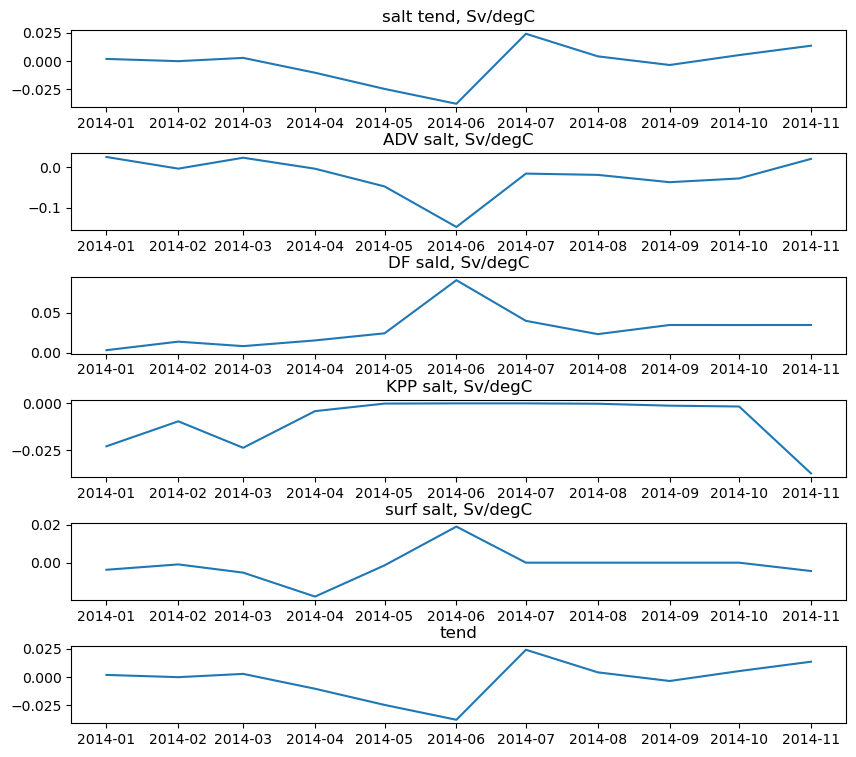

In [197]:
# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space

ax = plt.subplot(611)
ax.plot(datetimes[:-1],JtendSfull)
ax.set_title("salt tend, Sv/degC")

ax = plt.subplot(612)
ax.plot(datetimes[:-1],JADVSfull)
ax.set_title("ADV salt, Sv/degC")

ax = plt.subplot(613)
ax.plot(datetimes[:-1],JDFSfull)
ax.set_title("DF sald, Sv/degC")

ax = plt.subplot(614)
ax.plot(datetimes[:-1],JKPPSfull)
ax.set_title("KPP salt, Sv/degC")

ax = plt.subplot(615)
ax.plot(datetimes[:-1],JsurfSfull)
ax.set_title("surf salt, Sv/degC")

ax = plt.subplot(616)
ax.plot(datetimes[:-1],(JADVSfull+JDFSfull+JKPPSfull+JsurfSfull))
ax.set_title("tend from terms")

# plot a time series of the J terms

In [ ]:
# we can look at the impact of salt on the surface